In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import torch

In [2]:
conn = sqlite3.connect('fantasy_football_data.db')

In [3]:
# query to get average stats per game over last 2 years
# I tested both 3 years and 2 years of stats and 2 years performed better so that's why I switched to 2 years
player_stats_pg = pd.read_sql('''
    WITH sum_stats AS (
        SELECT 
            Player, Year, Tm, FantPos, Age, 
            SUM(G) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "G",
            SUM(GS) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "GS",
            SUM(Cmp) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Cmp",
            SUM(Pass_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_Att",
            SUM(Pass_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_Yds",
            SUM(Pass_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_TD",
            SUM(Int) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Int",
            SUM(Rush_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_Att",
            SUM(Rush_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_Yds",
            SUM("Y/A") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/A",
            SUM(Rush_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_TD",
            SUM(Tgt) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Tgt",
            SUM(Rec) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec",
            SUM(Rec_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec_Yds",
            SUM("Y/R") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/R",
            SUM(Rec_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec_TD",
            SUM(Fmb) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Fmb",
            SUM(FL) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "FL",
            SUM(Tot_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Tot_TD",
            PPR/G,
            PPR,
            LAG(Tm, 1) OVER (PARTITION BY Player ORDER BY Year) AS Tm_Last_Yr
        FROM
            player_stats)
        
    SELECT
        Player, Year, Tm, FantPos, Age, G, GS, GS/G, Cmp/G, Pass_Att/G, Pass_Yds/G, Pass_TD/G, Int/G, Rush_Att/G, Rush_Yds/G, "Y/A",
        Rush_TD/G, Tgt/G, Rec/G, Rec_Yds/G, "Y/R", Rec_TD/G, Fmb/G, FL/G, Tot_TD/G, "PPR/G", PPR, Tm_Last_Yr
    FROM
        sum_stats
        '''
, conn)
player_stats_pg['Changed_Teams'] = np.where(player_stats_pg['Tm'] != player_stats_pg['Tm_Last_Yr'], 1, 0)
player_stats_pg['PPR/G'].fillna(0, inplace=True)
player_stats_pg['GS/G'] = player_stats_pg['GS']/player_stats_pg['G']
player_stats_pg.query('Year > 2016', inplace=True)

rookies = player_stats_pg[player_stats_pg['G'].isnull()] # saving rookies for later
player_stats_pg.dropna(subset=['G'], inplace=True)

player_stats_pg_2024 = player_stats_pg[player_stats_pg['Year']==2024] # saving 2024 stats for final predictions

player_stats_pg.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
1,A.J. Brown,2020,TEN,WR,23.0,16.0,11.0,0.687500,0.0,0.000000,...,65.687500,20.21,0.500000,0.062500,0.000000,0.562500,17.678571,247.5,TEN,0
2,A.J. Brown,2021,TEN,WR,24.0,30.0,23.0,0.766667,0.0,0.000000,...,70.866667,35.57,0.633333,0.100000,0.033333,0.700000,13.915385,180.9,TEN,0
3,A.J. Brown,2022,PHI,WR,25.0,27.0,25.0,0.925926,0.0,0.074074,...,72.000000,29.15,0.592593,0.074074,0.037037,0.629630,17.623529,299.6,TEN,1
4,A.J. Brown,2023,PHI,WR,26.0,30.0,29.0,0.966667,0.0,0.066667,...,78.833333,30.79,0.533333,0.066667,0.066667,0.533333,17.035294,289.6,PHI,0
5,A.J. Brown,2024,PHI,WR,27.0,34.0,33.0,0.970588,0.0,0.000000,...,86.823529,30.74,0.529412,0.117647,0.117647,0.529412,0.000000,NaN,PHI,0


In [4]:
player_stats_pg.query('Player =="Christian McCaffrey"')

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
1067,Christian McCaffrey,2018,CAR,RB,22.0,16.0,10.0,0.625000,0.000000,0.000000,...,40.687500,8.14,0.312500,0.125000,0.062500,0.437500,24.093750,385.5,CAR,0
1068,Christian McCaffrey,2019,CAR,RB,23.0,32.0,26.0,0.812500,0.031250,0.031250,...,47.437500,16.24,0.343750,0.187500,0.062500,0.625000,29.450000,471.2,CAR,0
1069,Christian McCaffrey,2020,CAR,RB,24.0,32.0,32.0,1.000000,0.031250,0.093750,...,58.500000,16.76,0.312500,0.156250,0.031250,1.000000,30.133333,90.4,CAR,0
1070,Christian McCaffrey,2021,CAR,RB,25.0,19.0,19.0,1.000000,0.000000,0.105263,...,60.736842,17.42,0.263158,0.052632,0.000000,1.315789,18.214286,127.5,CAR,0
1071,Christian McCaffrey,2022,2TM,RB,26.0,10.0,10.0,1.000000,0.000000,0.000000,...,49.200000,18.03,0.200000,0.100000,0.000000,0.800000,20.964706,356.4,CAR,1
1072,Christian McCaffrey,2023,SFO,RB,27.0,24.0,23.0,0.958333,0.041667,0.041667,...,45.166667,17.99,0.250000,0.083333,0.000000,0.625000,24.456250,391.3,2TM,1
1073,Christian McCaffrey,2024,SFO,RB,28.0,33.0,32.0,0.969697,0.030303,0.030303,...,39.545455,17.14,0.363636,0.121212,0.060606,1.030303,0.000000,NaN,SFO,0


In [5]:
# splitting by position
# even though before this didn't seem to make much of a difference, so I'm going to still try it
qb_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='QB'].dropna().reset_index(drop=True) # dropna drops 2024 data
wr_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='WR'].dropna().reset_index(drop=True)
rb_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='RB'].dropna().reset_index(drop=True)
te_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='TE'].dropna().reset_index(drop=True)

In [6]:
qb_stats_pg.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
0,A.J. McCarron,2017,CIN,QB,27.0,8.0,3.0,0.375,9.875,14.875,...,0.0,0.0,0.0,0.125,0.125,0.00,0.866667,2.6,CIN,0
1,A.J. McCarron,2018,OAK,QB,28.0,4.0,0.0,0.000,1.750,3.500,...,0.0,0.0,0.0,0.000,0.000,0.00,0.050000,0.1,CIN,1
2,A.J. McCarron,2019,HOU,QB,29.0,5.0,0.0,0.000,1.600,3.400,...,0.0,0.0,0.0,0.200,0.000,0.00,8.450000,16.9,OAK,1
3,A.J. McCarron,2020,HOU,QB,30.0,4.0,1.0,0.250,5.500,10.000,...,0.0,0.0,0.0,0.250,0.000,0.25,0.400000,0.8,HOU,0
4,A.J. McCarron,2023,CIN,QB,33.0,4.0,1.0,0.250,5.500,9.500,...,0.0,0.0,0.0,0.000,0.000,0.25,0.400000,0.8,HOU,1


In [7]:
corr_mat = qb_stats_pg.dropna().drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)
# much better correlation scores than when the stats weren't per game

PPR/G            1.000000
PPR              0.878407
Pass_TD/G        0.618939
GS               0.618009
Pass_Yds/G       0.595282
G                0.576521
Cmp/G            0.561965
GS/G             0.557919
Pass_Att/G       0.544045
Rush_Att/G       0.451839
Rush_Yds/G       0.380412
Rush_TD/G        0.363639
Tot_TD/G         0.357026
Fmb/G            0.317349
Y/A              0.247419
FL/G             0.218502
Int/G            0.210047
Y/R              0.068179
Rec_TD/G        -0.020003
Age             -0.031431
Tgt/G           -0.039316
Rec/G           -0.044036
Rec_Yds/G       -0.046480
Changed_Teams   -0.331969
Name: PPR/G, dtype: float64

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# qb features
qb_features_pg = qb_stats_pg[['Year', 'GS/G', 'Cmp/G', 'Pass_Att/G', 'Pass_Yds/G', 'Pass_TD/G', 'Int/G', 'Rush_Att/G', 'Rush_Yds/G', 'Rush_TD/G', 'Changed_Teams']]
qb_info_pg = qb_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
qb_PPR_pg = qb_stats_pg[['Year','PPR/G']]

# scaling the data
scaler_qb = StandardScaler()
qb_features_pg = pd.DataFrame(scaler_qb.fit_transform(qb_features_pg), columns=qb_features_pg.columns)
scalerPPR_qb = StandardScaler() # need this to unscale the data later
qb_PPR_pg = pd.DataFrame(scalerPPR_qb.fit_transform(qb_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
qb_features_pg['Year'] = qb_stats_pg['Year']
qb_features_pg['Changed_Teams'] = qb_stats_pg['Changed_Teams']
qb_PPR_pg['Year'] = qb_stats_pg['Year']

In [10]:
qb_features_pg.head()

,Year,GS/G,Cmp/G,Pass_Att/G,Pass_Yds/G,Pass_TD/G,Int/G,Rush_Att/G,Rush_Yds/G,Rush_TD/G,Changed_Teams
0,2017,-0.811949,-0.654155,-0.739144,-0.669438,-0.387358,-0.937957,-0.490122,-0.566970,-0.789042,0
1,2018,-1.814809,-1.674574,-1.676053,-1.650139,-1.488015,-1.627074,-1.446103,-0.885309,-0.789042,1
2,2019,-1.814809,-1.693412,-1.684290,-1.668612,-1.488015,-1.627074,-1.118338,-0.918169,-0.789042,1
3,2020,-1.146236,-1.203611,-1.140676,-1.196463,-1.488015,-0.937957,-0.353553,-0.125403,1.016209,0
4,2023,-1.146236,-1.203611,-1.181859,-1.163863,-1.488015,-0.937957,-0.763259,-0.084327,1.016209,1


In [11]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [12]:
# 12 fold cross validation
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [13]:
# linear regression only qbs
lr = LinearRegression()
results = cross_validate(lr, qb_features_pg.drop('Year', axis=1), qb_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.50186344 0.47996184 0.49810038 0.50988136 0.49522335 0.51136986
 0.48427076 0.49363875 0.50163865 0.49064234 0.50382126 0.49282461]
Test MSE: [0.46242629 0.71360307 0.50915104 0.38367375 0.55229533 0.35857879
 0.6658281  0.56705995 0.47003911 0.59273539 0.43978869 0.58063219]
Mean Train MSE: 0.4969363832713755
Mean Test MSE: 0.5246509762142048


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
# gradient boosted regression only qbs
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, qb_features_pg.drop('Year', axis=1), qb_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.28796646 0.26439254 0.27715836 0.29321368 0.28771454 0.29047384
 0.28014601 0.27969279 0.28117211 0.2832954  0.27833937 0.26927007]
Test MSE: [0.43357522 0.76408332 0.68691851 0.39607378 0.54880681 0.35883399
 0.65397365 0.67472089 0.65762243 0.61445652 0.52339951 0.70443705]
Mean Train MSE: 0.28106959617304134
Mean Test MSE: 0.5847418076614639


In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
# same neural network as before
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
def train(model, criterion, optmizer, num_epochs, X_train, y_train):
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return

def evaluate(model, X_train, y_train, X_test, y_test):
    model.eval()  
    with torch.no_grad():  # No need to compute gradients for evaluation
        train_predict = model(X_train)
        test_predict = model(X_test)

        train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
        test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())
    return train_mse, test_mse

In [18]:
# setting up data and parameters
X_tensor = torch.tensor(qb_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(qb_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = 64
output_size = 1
criterion = nn.MSELoss()
model = SimpleNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)

fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.2903343141078949
Test MSE: 0.48826590180397034

Fold 2
Train MSE: 0.29165148735046387
Test MSE: 0.5963641405105591

Fold 3
Train MSE: 0.31405773758888245
Test MSE: 0.6598545908927917

Fold 4
Train MSE: 0.3166087567806244
Test MSE: 0.5841348171234131

Fold 5
Train MSE: 0.32941368222236633
Test MSE: 0.7190324664115906

Fold 6
Train MSE: 0.32865917682647705
Test MSE: 0.4219025671482086

Fold 7
Train MSE: 0.3182308077812195
Test MSE: 0.7144274115562439

Fold 8
Train MSE: 0.27474266290664673
Test MSE: 0.8838520050048828

Fold 9
Train MSE: 0.28220900893211365
Test MSE: 0.6234577298164368

Fold 10
Train MSE: 0.3252377212047577
Test MSE: 0.7622697949409485

Fold 11
Train MSE: 0.31758153438568115
Test MSE: 0.4601709544658661

Fold 12
Train MSE: 0.31317138671875
Test MSE: 0.6070950031280518

Mean Train Loss: 0.3084914982318878
Mean Test Loss: 0.6267356276512146


In [19]:
# 2023 data
qb_features_pg_2023 = qb_features_pg[qb_features_pg['Year']==2023].drop('Year', axis=1)
qb_PPR_pg_2023 = qb_PPR_pg[qb_PPR_pg['Year']==2023].drop('Year', axis=1)
qb_info_pg_2023 = qb_info_pg[qb_info_pg['Year']==2023]

In [20]:
# train and test data
X_train = torch.tensor(qb_features_pg[qb_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(qb_PPR_pg[qb_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(qb_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(qb_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()  
with torch.no_grad():  # don't need to compute gradients for evaluation
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 0.4765
Epoch [200/1000], Loss: 0.4435
Epoch [300/1000], Loss: 0.4206
Epoch [400/1000], Loss: 0.4034
Epoch [500/1000], Loss: 0.3889
Epoch [600/1000], Loss: 0.3751
Epoch [700/1000], Loss: 0.3625
Epoch [800/1000], Loss: 0.3481
Epoch [900/1000], Loss: 0.3330
Epoch [1000/1000], Loss: 0.3148
Train Loss: 0.31457269191741943
Test Loss: 0.6711228489875793


In [21]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': qb_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([qb_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = qb_stats_pg['PPR/G'][qb_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR_qb.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = qb_stats_pg['PPR'][qb_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*qb_stats_pg['GS/G'][qb_stats_pg['Year']==2023].reset_index(drop=True)*16
result['Predicted Rank'] = result['Predicted PPR/G'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR/G'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

result.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
24,Jalen Hurts,2023,PHI,QB,25.0,20.988235,31.148211,356.8,498.371368,1,2
42,Lamar Jackson,2023,BAL,QB,26.0,20.700000,20.574997,331.2,329.199951,2,3
17,Deshaun Watson,2023,CLE,QB,28.0,14.466667,20.500320,86.8,328.005127,3,23
55,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,20.135714,280.2,322.171417,4,12
33,Josh Allen,2023,BUF,QB,27.0,23.094118,20.130154,392.6,322.082458,5,1


The models trained on data split by position were all overfit and performed quite bad on the test data. In addition the cross validation was inconsistent. I think this may be due to the fact that splitting up by position results in less train and test data. I'm going predicting PPR/G without splitting up by position.

In [22]:
corr_mat = player_stats_pg.drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)

PPR/G            1.000000
PPR              0.924478
GS/G             0.506338
GS               0.486816
Tot_TD/G         0.472692
Rec/G            0.375526
Rec_Yds/G        0.366811
Tgt/G            0.358360
Pass_TD/G        0.355057
Pass_Yds/G       0.342726
Fmb/G            0.342721
Cmp/G            0.333658
Pass_Att/G       0.329776
Rec_TD/G         0.323269
FL/G             0.304385
Rush_TD/G        0.301223
Rush_Yds/G       0.296987
Rush_Att/G       0.285529
Int/G            0.263266
Y/A              0.232757
G                0.229862
Age              0.056670
Y/R              0.034939
Changed_Teams   -0.195635
Name: PPR/G, dtype: float64

In [23]:
# player features
player_features_pg = player_stats_pg.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'PPR/G', 'Tm_Last_Yr'], axis=1)
player_info_pg = player_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
player_PPR_pg = player_stats_pg[['Year', 'PPR/G']][player_stats_pg['Year'] < 2024].reset_index(drop=True)

# scaling the data
scaler = StandardScaler()
player_features_pg = pd.DataFrame(scaler.fit_transform(player_features_pg), columns=player_features_pg.columns)
scalerPPR = StandardScaler() # using a different scaler so I can unscale the data later
player_PPR_pg = pd.DataFrame(scalerPPR.fit_transform(player_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
player_features_pg['Year'] = player_stats_pg['Year'].reset_index(drop=True)
player_features_pg['Changed_Teams'] = player_stats_pg['Changed_Teams'].reset_index(drop=True)
player_PPR_pg['Year'] = player_stats_pg['Year'][player_stats_pg['Year'] < 2024].reset_index(drop=True)

# saving 2024 data
player_features_pg_2024 = player_features_pg[player_features_pg['Year'] == 2024].reset_index(drop=True).drop('Year', axis=1)
player_features_pg = player_features_pg[player_features_pg['Year'] < 2024].reset_index(drop=True)
player_info_pg_2024 = player_info_pg[player_info_pg['Year'] == 2024].reset_index(drop=True)
player_info_pg = player_info_pg[player_info_pg['Year'] < 2024].reset_index(drop=True)

In [24]:
# linear regression all players
lr = LinearRegression()
results = cross_validate(lr, player_features_pg.drop('Year', axis=1), player_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.37238625 0.3687807  0.36888109 0.35848415 0.36333834 0.36590893
 0.36375157 0.36628208 0.3663944  0.36180454 0.36902771 0.36758561]
Test MSE: [0.30228664 0.34556049 0.34286202 0.45771646 0.4041706  0.37650123
 0.39857489 0.3695095  0.37136084 0.42655277 0.33986181 0.36105637]
Mean Train MSE: 0.3660521139397966
Mean Test MSE: 0.374667801262327


In [25]:
# gradient boosted regression all players
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, player_features_pg.drop('Year', axis=1), player_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.29916508 0.29565146 0.29665499 0.2905942  0.29254993 0.29373386
 0.29227788 0.29533191 0.29764508 0.28879369 0.29591097 0.29642774]
Test MSE: [0.32387053 0.34591217 0.34373473 0.46069705 0.42200813 0.39323989
 0.39767653 0.35739178 0.35554452 0.41927154 0.35157344 0.3570968 ]
Mean Train MSE: 0.29456139854380736
Mean Test MSE: 0.37733475972049235


In [26]:
# setting up data and paramters
X_tensor = torch.tensor(player_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(player_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)
    
fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.36264437437057495
Test MSE: 0.31045764684677124

Fold 2
Train MSE: 0.35765764117240906
Test MSE: 0.34484153985977173

Fold 3
Train MSE: 0.36048707365989685
Test MSE: 0.34043413400650024

Fold 4
Train MSE: 0.3469074070453644
Test MSE: 0.4527208209037781

Fold 5
Train MSE: 0.35424867272377014
Test MSE: 0.3846896290779114

Fold 6
Train MSE: 0.3563489317893982
Test MSE: 0.36797136068344116

Fold 7
Train MSE: 0.3498256504535675
Test MSE: 0.4016929864883423

Fold 8
Train MSE: 0.35987842082977295
Test MSE: 0.3571644127368927

Fold 9
Train MSE: 0.3564022183418274
Test MSE: 0.3631110191345215

Fold 10
Train MSE: 0.345505028963089
Test MSE: 0.41247397661209106

Fold 11
Train MSE: 0.356729656457901
Test MSE: 0.3395436406135559

Fold 12
Train MSE: 0.35287711024284363
Test MSE: 0.3605174124240875

Mean Train Loss: 0.3549593389034271
Mean Test Loss: 0.36963486671447754


In [27]:
# 2023 data
player_features_pg_2023 = player_features_pg[player_features_pg['Year']==2023].drop('Year', axis=1)
player_PPR_pg_2023 = player_PPR_pg[player_PPR_pg['Year']==2023].drop('Year', axis=1)
player_info_pg_2023 = player_info_pg[player_info_pg['Year']==2023]

In [28]:
# train and test data
X_train = torch.tensor(player_features_pg[player_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(player_PPR_pg[player_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(player_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(player_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 0.4386
Epoch [200/1000], Loss: 0.3868
Epoch [300/1000], Loss: 0.3715
Epoch [400/1000], Loss: 0.3627
Epoch [500/1000], Loss: 0.3566
Epoch [600/1000], Loss: 0.3521
Epoch [700/1000], Loss: 0.3485
Epoch [800/1000], Loss: 0.3456
Epoch [900/1000], Loss: 0.3431
Epoch [1000/1000], Loss: 0.3406
Train Loss: 0.3406050503253937
Test Loss: 0.3614191710948944


In [29]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': player_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([player_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = player_stats_pg['PPR/G'][player_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = player_stats_pg['PPR'][player_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*16
# for qbs I'm multiplying PPR/G * G/GS because qbs generally only play when they start
result.loc[result['FantPos'] == 'QB', 'Predicted PPR'] = (result['Predicted PPR/G'] * 
    player_stats_pg.loc[player_stats_pg['Year'] == 2023, 'GS/G'].reset_index(drop=True) * 16)
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

pred_2023 = result.copy()
pred_2023

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
259,Josh Allen,2023,BUF,QB,27.0,23.094118,23.247149,392.6,371.954376,1,2
85,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.160339,164.4,370.565430,2,92
213,Jalen Hurts,2023,PHI,QB,25.0,20.988235,21.935541,356.8,350.968658,3,5
273,Justin Jefferson,2023,MIN,WR,24.0,20.220000,20.065653,202.2,321.050446,4,65
391,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,19.905092,280.2,318.481476,5,17
...,...,...,...,...,...,...,...,...,...,...,...
159,Easton Stick,2023,LAC,QB,28.0,13.520000,2.658984,67.6,0.000000,501,189
53,C.J. Beathard,2023,JAX,QB,30.0,3.071429,3.061430,21.5,0.000000,501,311
323,Logan Woodside,2023,ATL,QB,28.0,-0.300000,2.456921,-0.3,0.000000,501,501
342,Matt Barkley,2023,JAX,QB,33.0,-0.300000,3.876737,-0.3,0.000000,501,501


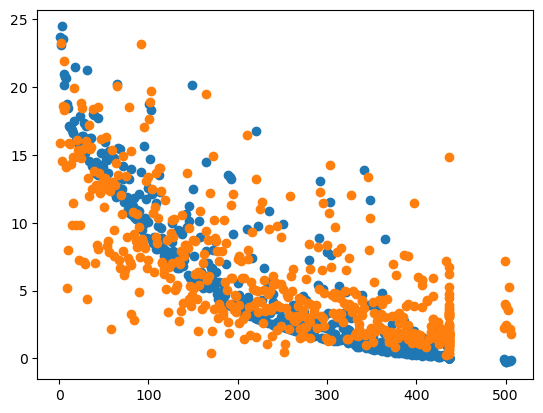

In [30]:
plt.scatter(result['Actual Rank'], result['Actual PPR/G'])
plt.scatter(result['Actual Rank'], result['Predicted PPR/G'])

# Rookies

In [31]:
rookies.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
0,A.J. Brown,2019,TEN,WR,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.568750,217.1,None,1
23,A.T. Perry,2023,NOR,WR,24.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.060000,60.6,None,1
25,AJ Dillon,2020,GNB,RB,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.663636,40.3,None,1
32,Aaron Fuller,2021,SEA,WR,24.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,None,1
34,Aaron Jones,2017,GNB,RB,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.666667,80.0,None,1


In [32]:
rookies.to_sql('rookies', conn, if_exists='replace', index=False)

1027

In [33]:
# joining rookies with college stats
rookie_stats_pg = pd.read_sql('''
    WITH temp AS (
        SELECT 
            Player, Year, Tm, FantPos, Age, "PPR/G", PPR FROM rookies
    )
    SELECT 
        t.Player, t.Tm, t.Year, c.Pick, t.FantPos, t.Age, c.School, c.Conf, c.G as G, c.Cmp/G as "Cmp/G", 
        c.Pass_Att/G as "Pass_Att/G", c.Cmp_Pct, c.Pass_Yds/G as "Pass_Yds/G", c."Pass_Y/A", c.Pass_TD/G as "Pass_TD/G",
        c.Int/G as "Int/G", c.PR, c.Rush_Att/G as "Rush_Att/G", c.Rush_Yds/G as "Rush_Yds/G", c."Rush_Y/A", 
        c.Rush_TD/G as "Rush_TD/G", c.Rec/G as "Rec/G", c.Rec_Yds/G as "Rec_Yds/G", c."Y/R", c.Rec_TD/G as "Rec_TD/G", 
        c.Plays/G as "Plays/G", c.Tot_Yds/G as "Tot_Yds/G", c."Y/P", c.Tot_TD/G as "Tot_TD/G", t."PPR/G", t.PPR
    FROM 
        temp t
    LEFT JOIN 
        college_stats c
    ON
        t.Player = c.Player'''
    , conn)
rookie_stats_pg.dropna(subset=['G'], inplace=True) # na rows are undrafted players
rookie_stats_pg

,Player,Tm,Year,Pick,FantPos,Age,School,Conf,G,Cmp/G,...,Rec/G,Rec_Yds/G,Y/R,Rec_TD/G,Plays/G,Tot_Yds/G,Y/P,Tot_TD/G,PPR/G,PPR
0,A.J. Brown,TEN,2019,51.0,WR,22.0,Ole Miss,SEC,12.0,0.0,...,7.083333,110.000000,15.5,0.500000,7.083333,110.000000,15.5,0.500000,13.568750,217.1
1,A.T. Perry,NOR,2023,195.0,WR,24.0,Wake Forest,ACC,13.0,0.0,...,6.230769,84.307692,13.5,0.846154,6.230769,84.307692,13.5,0.846154,6.060000,60.6
2,AJ Dillon,GNB,2020,62.0,RB,22.0,Boston College,ACC,13.0,0.0,...,1.000000,15.000000,15.0,0.076923,25.461538,144.615385,5.7,1.153846,3.663636,40.3
4,Aaron Jones,GNB,2017,182.0,RB,23.0,UTEP,CUSA,12.0,0.0,...,2.333333,19.416667,8.3,0.250000,21.416667,167.166667,7.8,1.666667,6.666667,80.0
7,Adam Shaheen,CHI,2017,45.0,FB,23.0,Ashland,G-MAC,11.0,0.0,...,6.363636,73.000000,11.5,0.909091,6.363636,73.000000,11.5,0.909091,3.284615,42.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,Zack Moss,BUF,2020,86.0,RB,23.0,Utah,Pac-12,13.0,0.0,...,2.153846,29.846154,13.9,0.153846,20.230769,138.769231,6.9,1.307692,7.815385,101.6
1022,Zamir White,LVR,2022,122.0,RB,23.0,Georgia,SEC,15.0,0.0,...,0.600000,5.000000,8.3,0.000000,11.266667,62.066667,5.5,0.733333,0.500000,7.0
1023,Zander Horvath,LAC,2022,260.0,FB,24.0,Purdue,Big Ten,8.0,0.0,...,2.125000,13.500000,6.4,0.000000,13.500000,53.500000,4.0,0.375000,1.240000,18.6
1024,Zay Flowers,BAL,2023,22.0,WR,23.0,Boston College,ACC,12.0,0.0,...,6.500000,89.750000,13.8,1.000000,7.500000,93.083333,12.4,1.000000,12.900000,206.4


In [34]:
corr_mat = rookie_stats_pg.drop(['Player', 'Year', 'Tm', 'FantPos', 'School', 'Conf'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)
# unsurprisingly none of the stats have that good of a correlation with PPR/G
# where the player was picked is the best feature

PPR/G         1.000000
PPR           0.907427
Pass_TD/G     0.223141
Pass_Yds/G    0.219681
Cmp/G         0.216304
PR            0.215885
Pass_Y/A      0.215053
Pass_Att/G    0.213399
Cmp_Pct       0.213358
Int/G         0.203757
Rush_TD/G     0.179851
Rush_Att/G    0.154480
Rush_Yds/G    0.133797
Tot_TD/G      0.099287
Plays/G       0.073777
Tot_Yds/G     0.069228
Rush_Y/A      0.022913
G             0.011890
Rec_TD/G     -0.021237
Rec/G        -0.033980
Rec_Yds/G    -0.034724
Y/R          -0.166489
Y/P          -0.179265
Age          -0.295967
Pick         -0.473665
Name: PPR/G, dtype: float64

In [35]:
# rookies features
rookie_features_pg = rookie_stats_pg.drop(['Player', 'Tm', 'FantPos', 'School', 'Conf', 'PPR', 'PPR/G'], axis=1)
rookie_info_pg = rookie_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age', 'School']]
rookie_PPR_pg = rookie_stats_pg[['Year', 'PPR/G']][rookie_stats_pg['Year'] < 2024].reset_index(drop=True)

# scaling the data
scaler_rookies = StandardScaler()
rookie_features_pg = pd.DataFrame(scaler_rookies.fit_transform(rookie_features_pg), columns=rookie_features_pg.columns)
scalerPPR_rookies = StandardScaler() 
rookie_PPR_pg = pd.DataFrame(scalerPPR_rookies.fit_transform(rookie_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
rookie_features_pg['Year'] = rookie_stats_pg['Year'].reset_index(drop=True)
rookie_PPR_pg['Year'] = rookie_stats_pg['Year'][rookie_stats_pg['Year'] < 2024].reset_index(drop=True)

# saving 2024 data
rookie_features_pg_2024 = rookie_features_pg[rookie_features_pg['Year'] == 2024].reset_index(drop=True).drop('Year', axis=1)
rookie_features_pg = rookie_features_pg[rookie_features_pg['Year'] < 2024].reset_index(drop=True)
rookie_info_pg_2024 = rookie_info_pg[rookie_info_pg['Year'] == 2024].reset_index(drop=True)
rookie_info_pg = rookie_info_pg[rookie_info_pg['Year'] < 2024].reset_index(drop=True)

In [36]:
# linear regression rookies
lr = LinearRegression()
results = cross_validate(lr, rookie_features_pg.drop('Year', axis=1), rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")
# as expected the fit is bad because the data is not great

Train MSE: [0.57922927 0.59188628 0.60639989 0.60732657 0.59795266 0.59580288
 0.57216249 0.58603659 0.59555915 0.58117317 0.57122766 0.57733658]
Test MSE: [0.75433366 0.61979759 0.45955107 0.51464266 0.5498298  0.56771587
 0.84997597 0.71414141 0.60849086 0.81861677 0.86413897 0.78801645]
Mean Train MSE: 0.5885077668058625
Mean Test MSE: 0.675770923413464


In [37]:
# the data is overfit a little bit and since most of the stats aren't highly correlated I'm going to use less features
# I chose PR, Tot_Yds/G, and Tot_TD/G because they are combined stats and represent all of the other stats
# PR (passer rating) is calculated from attempts, completions, yards, tds, and ints
lr = LinearRegression()
results = cross_validate(lr, rookie_features_pg[['Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']], rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.59097204 0.61538407 0.621464   0.62804706 0.62034012 0.61324177
 0.59754978 0.60738284 0.61704546 0.60032376 0.5920457  0.60057781]
Test MSE: [0.81293673 0.54792758 0.4886221  0.4083338  0.49667872 0.5712369
 0.74703484 0.63435809 0.52703764 0.72898203 0.8271567  0.71208367]
Mean Train MSE: 0.6086978666931028
Mean Test MSE: 0.6251990680922582


In [38]:
# fit was a little better so I'm going to continue using only those stats
rookie_features_pg = rookie_features_pg[['Year', 'Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']]
rookie_features_pg.head()

,Year,Pick,Age,PR,Tot_Yds/G,Tot_TD/G
0,2019,-0.893356,-0.608477,-0.386174,0.854419,-0.346042
1,2023,1.062569,1.177698,-0.386174,0.266840,0.373470
2,2020,-0.743945,-0.608477,-0.386174,1.646068,1.013037
3,2017,0.885993,0.284610,-0.386174,2.161813,2.078981
4,2017,-0.974853,0.284610,-0.386174,0.008234,0.504291


In [39]:
# gradient boosted regression rookies
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, rookie_features_pg.drop('Year', axis=1), rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.40245115 0.39086631 0.40366088 0.41259056 0.40185566 0.3991404
 0.39108384 0.38966439 0.39155351 0.39105943 0.39261462 0.38087517]
Test MSE: [0.65360325 0.64750516 0.46177658 0.31606128 0.48713095 0.56291435
 0.78711706 0.63866082 0.62045858 0.64107026 0.80071718 0.84227919]
Mean Train MSE: 0.39561799337988895
Mean Test MSE: 0.6216078879538222


In [40]:
# data and parameters
X_tensor = torch.tensor(rookie_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(rookie_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = int(X_tensor.shape[1]*2/3)
output_size = 1
criterion = nn.MSELoss()
model = SimpleNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)

fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.5401030778884888
Test MSE: 0.722808301448822

Fold 2
Train MSE: 0.5750770568847656
Test MSE: 0.5347402691841125

Fold 3
Train MSE: 0.5739677548408508
Test MSE: 0.433921217918396

Fold 4
Train MSE: 0.584399402141571
Test MSE: 0.32512351870536804

Fold 5
Train MSE: 0.5826848149299622
Test MSE: 0.4339783489704132

Fold 6
Train MSE: 0.5612308382987976
Test MSE: 0.5666102170944214

Fold 7
Train MSE: 0.6530945897102356
Test MSE: 0.8153723478317261

Fold 8
Train MSE: 0.6290625333786011
Test MSE: 0.6704031229019165

Fold 9
Train MSE: 0.5813812017440796
Test MSE: 0.5692972540855408

Fold 10
Train MSE: 0.5538480877876282
Test MSE: 0.6461442112922668

Fold 11
Train MSE: 0.542251706123352
Test MSE: 0.8063218593597412

Fold 12
Train MSE: 0.5633731484413147
Test MSE: 0.7152658700942993

Mean Train Loss: 0.5783728957176208
Mean Test Loss: 0.6033322215080261


In [41]:
# 2023 data
rookie_features_pg_2023 = rookie_features_pg[rookie_features_pg['Year']==2023].drop('Year', axis=1)
rookie_PPR_pg_2023 = rookie_PPR_pg[rookie_PPR_pg['Year']==2023].drop('Year', axis=1)
rookie_info_pg_2023 = rookie_info_pg[rookie_info_pg['Year']==2023]

In [42]:
# train and test data
X_train = torch.tensor(rookie_features_pg[rookie_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(rookie_PPR_pg[rookie_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(rookie_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(rookie_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():  
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 0.9289
Epoch [200/1000], Loss: 0.8076
Epoch [300/1000], Loss: 0.7046
Epoch [400/1000], Loss: 0.6356
Epoch [500/1000], Loss: 0.5978
Epoch [600/1000], Loss: 0.5778
Epoch [700/1000], Loss: 0.5690
Epoch [800/1000], Loss: 0.5653
Epoch [900/1000], Loss: 0.5640
Epoch [1000/1000], Loss: 0.5635
Train Loss: 0.5634941458702087
Test Loss: 0.6254178285598755


In [43]:
# I think this good for now, try other models later like ridge regression because data is overfit

In [44]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': rookie_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([rookie_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = rookie_stats_pg['PPR/G'][rookie_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR_rookies.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = rookie_stats_pg['PPR'][rookie_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*16
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

pred_rookies_2023 = result.copy()
pred_rookies_2023

,Player,Year,Tm,FantPos,Age,School,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
4,Bijan Robinson,2023,ATL,RB,21.0,Texas,14.488235,14.001832,246.3,224.029312,1,3
9,C.J. Stroud,2023,HOU,QB,22.0,Ohio State,18.400000,13.111530,276.0,209.784485,2,2
8,Bryce Young,2023,CAR,QB,22.0,Alabama,9.775000,12.716820,156.4,203.469116,3,13
2,Anthony Richardson,2023,IND,QB,21.0,Florida,18.175000,12.583306,72.7,201.332901,4,28
29,Jahmyr Gibbs,2023,DET,RB,21.0,Alabama,16.140000,11.516136,242.1,184.258179,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
41,Kayshon Boutte,2023,NWE,WR,21.0,LSU,0.780000,2.580798,3.9,41.292763,47,62
43,Kenny McIntosh,2023,SEA,RB,23.0,Georgia,0.000000,2.580798,0.0,41.292763,47,69
49,Parker Washington,2023,JAX,WR,21.0,Penn State,4.355556,2.580798,39.2,41.292763,47,39
23,Dontayvion Wicks,2023,GNB,WR,22.0,Virginia,7.986667,2.580798,119.8,41.292763,47,18


In [45]:
# combining non rookies and rookies
pred_all_2023 = pd.concat([pred_2023, pred_rookies_2023.drop('School', axis=1)]).reset_index(drop=True)
pred_all_2023.drop(['Predicted Rank', 'Actual Rank'], axis=1, inplace=True)
pred_all_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR
0,Josh Allen,2023,BUF,QB,27.0,23.094118,23.247149,392.6,371.954376
1,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.160339,164.4,370.565430
2,Jalen Hurts,2023,PHI,QB,25.0,20.988235,21.935541,356.8,350.968658
3,Justin Jefferson,2023,MIN,WR,24.0,20.220000,20.065653,202.2,321.050446
4,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,19.905092,280.2,318.481476


In standard fantasy league formats (which is what I play with) each team starts 1 qb, 2 rbs, 2 wr, 1 te, and 1 flex (rb/wr/te). Because of this different positions are valued differently. Rbs are generally the most valued because each team needs 2 and they are relatively the most scarce. Qbs are the last valued because even though they are the highest scoring position, each team only needs and they are relatively the most scarce. Wrs are valued slightly less than rbs because they score around the same as rbs but there are more of them. Tes are valued similarly to rbs because they don't score as much but they are very scarce. If I make my overall rankings by sorting all the players by predicted PPR, my rankings will have qbs too high, so I need to account for this in my overall rankings. I did some research online and found that qbs are generally 70% as valuable as other positions so I'll start from there and see how it looks. I think I will also make some slight adjustments to rbs, wrs, and tes. 

In [46]:
# creating Adj PPR that adjusts for positional value
pred_all_2023['Adj Predicted PPR'] = pred_all_2023['Predicted PPR']
pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Predicted PPR']*0.7
pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Predicted PPR']*0.95
pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Predicted PPR']*1.05

pred_all_2023['Adj Actual PPR'] = pred_all_2023['Actual PPR']
pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Actual PPR']*0.7
pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Actual PPR']*0.95
pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Actual PPR']*1.05

pred_all_2023['Predicted OvRank'] = pred_all_2023['Adj Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_all_2023['Actual OvRank'] = pred_all_2023['Adj Actual PPR'].rank(ascending=False, method='min').astype(int)

pred_all_2023.sort_values('Predicted OvRank', inplace=True)
pred_all_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank
1,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.160339,164.4,370.565430,352.037158,156.18,1,103
3,Justin Jefferson,2023,MIN,WR,24.0,20.220000,20.065653,202.2,321.050446,304.997923,192.09,2,71
10,Austin Ekeler,2023,LAC,RB,28.0,13.242857,18.552866,185.4,296.845856,296.845856,185.40,3,80
8,Davante Adams,2023,LVR,WR,31.0,15.611765,18.811995,265.4,300.991913,285.942317,252.13,4,18
9,Tyreek Hill,2023,MIA,WR,29.0,23.525000,18.560448,376.4,296.967163,282.118805,357.58,5,3


In [47]:
# splitting up by position
pred_qb_2023 = pred_all_2023[pred_all_2023['FantPos']=='QB'].reset_index(drop=True)
pred_rb_2023 = pred_all_2023[pred_all_2023['FantPos']=='RB'].reset_index(drop=True)
pred_wr_2023 = pred_all_2023[pred_all_2023['FantPos']=='WR'].reset_index(drop=True)
pred_te_2023 = pred_all_2023[pred_all_2023['FantPos']=='TE'].reset_index(drop=True)

pred_qb_2023['Predicted PosRank'] = pred_qb_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_qb_2023['Actual PosRank'] = pred_qb_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2023['Predicted PosRank'] = pred_rb_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2023['Actual PosRank'] = pred_rb_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2023['Predicted PosRank'] = pred_wr_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2023['Actual PosRank'] = pred_wr_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2023['Predicted PosRank'] = pred_te_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2023['Actual PosRank'] = pred_te_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)

pred_qb_2023.sort_values('Predicted PosRank', inplace=True)
pred_rb_2023.sort_values('Predicted PosRank', inplace=True)
pred_wr_2023.sort_values('Predicted PosRank', inplace=True)
pred_te_2023.sort_values('Predicted PosRank', inplace=True)

pred_qb_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank,Predicted PosRank,Actual PosRank
0,Josh Allen,2023,BUF,QB,27.0,23.094118,23.247149,392.6,371.954376,260.368063,274.82,10,9,1,1
1,Jalen Hurts,2023,PHI,QB,25.0,20.988235,21.935541,356.8,350.968658,245.678061,249.76,12,20,2,2
2,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,19.905092,280.2,318.481476,222.937033,196.14,28,66,3,8
3,Kyler Murray,2023,ARI,QB,26.0,18.300000,19.695705,146.4,315.131287,220.591901,102.48,30,159,4,26
4,Deshaun Watson,2023,CLE,QB,28.0,14.466667,19.512915,86.8,312.206635,218.544644,60.76,32,224,5,34


In [48]:
# recombining positions
pred_all_2023 = pd.concat([pred_qb_2023, pred_rb_2023, pred_wr_2023, pred_te_2023]).reset_index(drop=True)
pred_all_2023.sort_values('Predicted OvRank', inplace=True)
pred_all_2023

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank,Predicted PosRank,Actual PosRank
212,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.160339,164.4,370.565430,352.037158,156.18,1,103,1,40
213,Justin Jefferson,2023,MIN,WR,24.0,20.220000,20.065653,202.2,321.050446,304.997923,192.09,2,71,2,33
79,Austin Ekeler,2023,LAC,RB,28.0,13.242857,18.552866,185.4,296.845856,296.845856,185.40,3,80,1,26
214,Davante Adams,2023,LVR,WR,31.0,15.611765,18.811995,265.4,300.991913,285.942317,252.13,4,18,3,10
215,Tyreek Hill,2023,MIA,WR,29.0,23.525000,18.560448,376.4,296.967163,282.118805,357.58,5,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Easton Stick,2023,LAC,QB,28.0,13.520000,2.658984,67.6,0.000000,0.000000,47.32,572,256,74,38
75,Kyle Trask,2023,TAM,QB,25.0,-0.050000,2.260112,-0.1,0.000000,0.000000,-0.07,572,569,74,74
76,Matt Barkley,2023,JAX,QB,33.0,-0.300000,3.876737,-0.3,0.000000,0.000000,-0.21,572,572,74,76
78,Logan Woodside,2023,ATL,QB,28.0,-0.300000,2.456921,-0.3,0.000000,0.000000,-0.21,572,572,74,76


I'm happy with my model's predictions for now so I'm going to train the models and predict for the upcoming 2024 season. I will come back and try other models and finetune new and existing models

# 2024 Predictions

In [49]:
# I made player_features 2024 and player_info_2024 earlier
player_features_pg_2024.head()

,G,GS,GS/G,Cmp/G,Pass_Att/G,Pass_Yds/G,Pass_TD/G,Int/G,Rush_Att/G,Rush_Yds/G,...,Rush_TD/G,Tgt/G,Rec/G,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,Changed_Teams
0,1.348001,2.068343,1.387512,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,-0.533764,-0.515803,...,-0.462313,2.487027,2.378459,3.183168,1.519241,2.643779,0.106551,0.867055,1.619737,0
1,-1.186766,-0.766751,-0.428509,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,-0.533764,-0.515803,...,-0.462313,-0.287704,-0.280875,0.263341,0.524929,1.811036,-0.585900,-0.536162,0.995025,0
2,1.136770,-0.199733,-0.479286,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,2.214800,1.813391,...,1.316514,-0.124324,-0.066931,-0.261924,0.233626,-0.762896,-0.401968,-0.536162,0.421781,0
3,0.714309,1.595827,1.467162,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,2.529785,2.904487,...,0.441218,0.612452,0.886861,0.161447,-0.061560,0.615996,0.885558,1.167744,0.788140,1
4,-0.341844,0.650796,1.467162,2.929062,2.897285,2.731589,3.052665,2.445516,-0.077348,-0.234361,...,-0.110940,-0.989994,-0.989105,-0.891010,-1.465638,-0.762896,2.030026,2.114358,-0.667719,0


In [50]:
# train and test data
X_train = torch.tensor(player_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(player_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(player_features_pg_2024.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():  
    train_predict = model(X_train)
    test_predict = model(X_test)
    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())

print(f'Train Loss: {train_mse}')

Epoch [100/1000], Loss: 0.4234
Epoch [200/1000], Loss: 0.3837
Epoch [300/1000], Loss: 0.3699
Epoch [400/1000], Loss: 0.3617
Epoch [500/1000], Loss: 0.3566
Epoch [600/1000], Loss: 0.3528
Epoch [700/1000], Loss: 0.3496
Epoch [800/1000], Loss: 0.3462
Epoch [900/1000], Loss: 0.3434
Epoch [1000/1000], Loss: 0.3410
Train Loss: 0.34096476435661316


In [51]:
# saving predictions
result = pd.DataFrame({'PPR/G': test_predict.flatten()})
result = pd.concat([player_info_pg_2024.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['PPR/G'] = scalerPPR.inverse_transform(result['PPR/G'].values.reshape(-1,1))
result['PPR'] = result['PPR/G']*16
result.loc[result['FantPos'] == 'QB', 'PPR'] = (result['PPR/G'] * player_stats_pg_2024['GS/G'].reset_index(drop=True) * 16)
result.sort_values('PPR', ascending=False, inplace=True)

pred_2024 = result.copy()
pred_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR
107,Jalen Hurts,2024,PHI,QB,26.0,22.759005,364.144073
221,Tyreek Hill,2024,MIA,WR,30.0,20.584961,329.359375
156,Lamar Jackson,2024,BAL,QB,27.0,20.516762,328.268188
32,CeeDee Lamb,2024,DAL,WR,25.0,20.463558,327.416931
131,Josh Allen,2024,Bills,QB,28.0,19.869385,317.910156


In [52]:
# I also made rookie_features_2024 and rookie_info_2024 earlier
rookie_features_pg_2024 = rookie_features_pg_2024[['Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']]
rookie_features_pg_2024.head()

,Pick,Age,PR,Tot_Yds/G,Tot_TD/G
0,-0.879773,-0.608477,-0.386174,-0.279273,0.247841
1,0.410594,-0.608477,-0.386174,1.165068,1.732549
2,-0.866190,0.284610,-0.386174,-0.372930,-0.346042
3,-0.458706,1.177698,-0.386174,0.415318,2.494699
4,-1.423086,2.070785,3.093090,-1.661266,-1.385338


In [53]:
# train and test data
X_train = torch.tensor(rookie_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(rookie_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(rookie_features_pg_2024.values, dtype=torch.float32)

# paramters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad(): 
    train_predict = model(X_train)
    test_predict = model(X_test)
    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())

print(f'Train Loss: {train_mse}')

Epoch [100/1000], Loss: 0.9448
Epoch [200/1000], Loss: 0.8604
Epoch [300/1000], Loss: 0.7783
Epoch [400/1000], Loss: 0.7167
Epoch [500/1000], Loss: 0.6835
Epoch [600/1000], Loss: 0.6627
Epoch [700/1000], Loss: 0.6468
Epoch [800/1000], Loss: 0.6340
Epoch [900/1000], Loss: 0.6260
Epoch [1000/1000], Loss: 0.6212
Train Loss: 0.6211413145065308


In [54]:
# saving predictions
result = pd.DataFrame({'PPR/G': test_predict.flatten()})
result = pd.concat([rookie_info_pg_2024.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['PPR/G'] = scalerPPR_rookies.inverse_transform(result['PPR/G'].values.reshape(-1,1))
result['PPR'] = result['PPR/G']*16
result.sort_values('PPR', ascending=False, inplace=True)

pred_rookies_2024 = result.copy()
pred_rookies_2024.head()

,Player,Year,Tm,FantPos,Age,School,PPR/G,PPR
13,J.J. McCarthy,2024,MIN,QB,22.0,Michigan,10.551034,168.816544
9,Caleb Williams,2024,CHI,QB,23.0,USC,10.551034,168.816544
18,Jayden Daniels,2024,WAS,QB,24.0,LSU,10.551034,168.816544
11,Drake Maye,2024,NWE,QB,23.0,North Carolina,10.316234,165.059738
4,Bo Nix,2024,DEN,QB,25.0,Oregon,10.174876,162.798019


In [67]:
# combining both predictions (non rookies and rookies)
pred_all_2024 = pd.concat([pred_2024, pred_rookies_2024.drop('School', axis=1)]).reset_index(drop=True)
pred_all_2024['PPR/G'] = pred_all_2024['PPR/G'].astype('float64')
pred_all_2024['Age'] = pred_all_2024['Age'].astype('int')

# adjusting PPR by position
pred_all_2024['Adj PPR'] = pred_all_2024['PPR']
pred_all_2024.loc[pred_all_2024['FantPos']=='QB', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='QB', 'PPR']*0.7
pred_all_2024.loc[pred_all_2024['FantPos']=='WR', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='WR', 'PPR']*0.95
pred_all_2024.loc[pred_all_2024['FantPos']=='TE', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='TE', 'PPR']*1.05
pred_all_2024['OvRank'] = pred_all_2024['Adj PPR'].rank(ascending=False, method='min').astype(int)
pred_all_2024.sort_values('OvRank', inplace=True)
pred_all_2024.drop('Adj PPR', axis=1, inplace=True)

# splitting up by position
pred_qb_2024 = pred_all_2024[pred_all_2024['FantPos']=='QB'].reset_index(drop=True)
pred_rb_2024 = pred_all_2024[pred_all_2024['FantPos']=='RB'].reset_index(drop=True)
pred_wr_2024 = pred_all_2024[pred_all_2024['FantPos']=='WR'].reset_index(drop=True)
pred_te_2024 = pred_all_2024[pred_all_2024['FantPos']=='TE'].reset_index(drop=True)

# making the positional rankings
pred_qb_2024['PosRank'] = pred_qb_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2024['PosRank'] = pred_rb_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2024['PosRank'] = pred_wr_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2024['PosRank'] = pred_te_2024['PPR'].rank(ascending=False, method='min').astype(int)

pred_qb_2024.sort_values('PosRank', inplace=True)
pred_rb_2024.sort_values('PosRank', inplace=True)
pred_wr_2024.sort_values('PosRank', inplace=True)
pred_te_2024.sort_values('PosRank', inplace=True)

# recombining the positions into one dataframe
pred_all_2024 = pd.concat([pred_qb_2024, pred_rb_2024, pred_wr_2024, pred_te_2024]).reset_index(drop=True)
pred_all_2024.sort_values('OvRank', inplace=True)

In [68]:
pred_all_2024 = pred_all_2024.round(2)
pred_qb_2024 = pred_rb_2024.round(2)
pred_rb_2024 = pred_rb_2024.round(2)
pred_wr_2024 = pred_wr_2024.round(2)
pred_te_2024 = pred_te_2024.round(2)

pred_all_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR,OvRank,PosRank
115,Tyreek Hill,2024,MIA,WR,30,20.58,329.36,1,1
116,CeeDee Lamb,2024,DAL,WR,25,20.46,327.42,2,2
37,Christian McCaffrey,2024,SFO,RB,28,19.33,309.26,3,1
117,Amon-Ra St. Brown,2024,DET,WR,25,18.78,300.42,4,3
118,Justin Jefferson,2024,MIN,WR,25,17.82,285.07,5,4


In [69]:
pred_qb_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR,OvRank,PosRank
0,Christian McCaffrey,2024,SFO,RB,28,19.33,309.26,3,1
1,Breece Hall,2024,NYJ,RB,23,14.66,234.49,14,2
2,Bijan Robinson,2024,ATL,RB,22,14.16,226.48,16,3
3,Jahmyr Gibbs,2024,DET,RB,22,13.85,221.60,20,4
4,Nick Chubb,2024,CLE,RB,29,13.70,219.20,22,5


In [70]:
pred_rb_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR,OvRank,PosRank
0,Christian McCaffrey,2024,SFO,RB,28,19.33,309.26,3,1
1,Breece Hall,2024,NYJ,RB,23,14.66,234.49,14,2
2,Bijan Robinson,2024,ATL,RB,22,14.16,226.48,16,3
3,Jahmyr Gibbs,2024,DET,RB,22,13.85,221.60,20,4
4,Nick Chubb,2024,CLE,RB,29,13.70,219.20,22,5


In [71]:
pred_wr_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR,OvRank,PosRank
0,Tyreek Hill,2024,MIA,WR,30,20.58,329.36,1,1
1,CeeDee Lamb,2024,DAL,WR,25,20.46,327.42,2,2
2,Amon-Ra St. Brown,2024,DET,WR,25,18.78,300.42,4,3
3,Justin Jefferson,2024,MIN,WR,25,17.82,285.07,5,4
4,Puka Nacua,2024,LAR,WR,23,17.66,282.55,6,5


In [72]:
pred_te_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR,OvRank,PosRank
0,Travis Kelce,2024,KAN,TE,35,15.89,254.24,7,1
1,T.J. Hockenson,2024,MIN,TE,27,12.73,203.67,25,2
2,Sam LaPorta,2024,DET,TE,23,12.64,202.31,27,3
3,George Kittle,2024,SFO,TE,31,11.74,187.82,44,4
4,Mark Andrews,2024,BAL,TE,29,11.56,184.95,47,5


In [73]:
# exporting to csv
pred_all_2024.to_csv('all_players.csv', index=False)
pred_qb_2024.to_csv('qbs.csv', index=False)
pred_rb_2024.to_csv('rbs.csv', index=False)
pred_wr_2024.to_csv('wrs.csv', index=False)
pred_te_2024.to_csv('tes.csv', index=False)

In [61]:
conn.close()